# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [359]:
DATA_FOLDER = '../../ADA2017-Tutorials/02 - Intro to Pandas/Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [360]:
from dateutil.parser import parse as strtodate
import pandas as pd
import numpy as np
import os, glob
import copy
EBOLA_FOLDER = os.path.join(DATA_FOLDER, "ebola")

### Solution

From analysing the three datasets, we observe similarities in the global structure of the csv files with few differences. Thus, we define the following variables that will allow us to compute the daily average number of new cases and deaths per month for each country:
- **tot_new_cases**: The total number of new cases registered in the current day.
- **tot_cum_cases**: The cumulative number of the sum of probable, suspected and confirmed cases.
- **tot_new_deaths**: The total number of new deaths registered in the current day.
- **tot_cum_deaths**: The cumulative number of deaths so far.

**How do we compute the averages(for new cases and deaths)?**
- For months with one csv file:
    - Take the number of new cases/deaths registered in the available day.
- For months with more than one csv file: 
    - Compute the difference between the cumulative value (of new deaths/cases) for the last available day (of the current month) and the first day in that month divided by difference of days.<br>
    E.g.: Let’s say for the month M the csv files available are 05/M,06/M ….. 27/M, then the daily average per month of new cases will be : cumulative_value(27/M)-cumulative_value(05/M)/(27-5)


### Processing functions

The following helper functions allow us to:
1. Handle the errors related to numerical conversion of data.
2. Extract the averages of new cases and deaths using the aformentioned formulas.

In [396]:
def convert_df_numerical(df, columns):
    ''' Converts the dataframe number to floats and
        ignores the human made errors replacing them by 0.'''
    def s_to_float(s):
        s, b = str(s), np.nan
        try:
            b = float(s.replace(',', ''))
        except:
            pass
        return b
    for column in columns:
        df[column] = df[column].apply(s_to_float)
    return df
    
def extract_result_df(df, country=''):
    ''' Extract the avg new cases and avg new deaths in 
        a given dataframe given the cumulative and daily values.'''
    df, df_result = df.copy(), []
    df['Month'] = df.index.strftime("%m-%Y")
    groupedby_month = df.groupby(['Month'])
    for name, group in groupedby_month:
        avg_new_cases, avg_new_deaths = 0, 0
        
        # The daily averages values takes into account the difference between 
        # the 1st and last cumulative values only if the group currently processed contains more than 1 file
        if len(group) > 1 and 'tot_cum_deaths' in group.columns.tolist():
            avg_new_deaths = (group.loc[group.last_valid_index()]['tot_cum_deaths']-group.loc[group.first_valid_index()]['tot_cum_deaths'])*1./(group.loc[group.last_valid_index()].name.day-group.loc[group.first_valid_index()].name.day)
        # We compute the daily average of deaths as the mean of the daily new deaths if there is no cumulative value
        elif 'tot_new_deaths' in group.columns.tolist() and ((not 'tot_cum_deaths' in group.columns.tolist()) or len(group) == 1 or avg_new_deaths < 0):
            avg_new_deaths = group['tot_new_deaths'].mean()
        
        
        if len(group) > 1 and 'tot_cum_cases' in group.columns.tolist():
            # This condition follows from our observation that the cumulative values for december 2014 
            # could have been written swapped with the daily values 
            if country == 'liberia' and name == '12-2014':
                avg_new_cases = (group.loc[group.last_valid_index()]['tot_new_cases']-group.loc[group.first_valid_index()]['tot_cum_cases'])*1./(group.loc[group.last_valid_index()].name.day-group.loc[group.first_valid_index()].name.day)
            else:
                avg_new_cases = (group.loc[group.last_valid_index()]['tot_cum_cases']-group.loc[group.first_valid_index()]['tot_cum_cases'])*1./(group.loc[group.last_valid_index()].name.day-group.loc[group.first_valid_index()].name.day)
    
        # We compute the daily cases of deaths as the means daily declared deaths if
        # the following conditions is verified 
        if (not 'tot_cum_cases' in group.columns.tolist()) or len(group) == 1 or avg_new_cases < 0:
            avg_new_cases = group['tot_new_cases'].mean()
        
        # Append the resulting daily averages for the currently processed month
        result = {'month': name, 
              'avg_new_cases': avg_new_cases, 
              'avg_new_death': avg_new_deaths}
        df_result.append(result)
    df_result = pd.DataFrame(df_result)
    return df_result

## Guinea

The Guinean dataset contains 3 months worth of data (from 2014-08-04 to 2014-10-01). From all the rows we are interested in, the following are only available in the first file:
- Number of confirmed cases among health workers
- Number of female confirmed cases
- Number of female probables cases
- Number of female suspects cases
- Number of male confirmed cases
- Number of male probables cases
- Number of male suspects cases
- Number of probables cases among health workers
- Number of suspects cases among health workers
    
After filtering the rows that are mostly empty over time, we are left with only few used for computing the following values:
- **tot_cum_cases** = Cumulative (confirmed + probable + suspects)
- **tot_new_cases** = Total new cases registered so far
- **tot_new_deaths** = New deaths registered
- **tot_cum_deaths** = Total deaths (confirmed + probables + suspects)

**Assumptions on the Liberian dataset:**
- The number of new cases and deaths among health workers is included in other totals
- The cumulative values so far includes the value from the current day

In [399]:
guinea_folder = os.path.join(EBOLA_FOLDER, "guinea_data/")

# Variables of interest
voi = ['Cumulative (confirmed + probable + suspects)', 'Total new cases registered so far',
       'New deaths registered', 'Total deaths (confirmed + probables + suspects)']

# Loading csv files separatly and concatenating them in a single dataframe
df = None
for file_path in glob.glob(guinea_folder+"*.csv"):
    # Make sure to parse the date as a DateTime value
    df_file = pd.read_csv(file_path, 
                          usecols=['Date', 'Description', 'Totals'],
                          parse_dates=['Date'])
    # Filter the rows depending on the variables we are interested in
    mask = df_file['Description'].apply(lambda x: x in voi)
    df_file = df_file[mask]
    
    # Concat the current DF with the rest
    df = df_file if df is None else pd.concat([df, df_file])

# Unstack the VOI to be columns in the intermediate dataframe
df = df.set_index(['Date', 'Description']).unstack(level=1)
df = pd.DataFrame(data=df.values, index=df.index.to_datetime(), columns=df.columns.levels[1])

# Convert the dataframe to numerical values and extract results using helper functions
df = convert_df_numerical(df, list(df.columns))
df.rename(inplace=True, columns={'Total new cases registered so far': 'tot_new_cases',
                                            'Cumulative (confirmed + probable + suspects)': 'tot_cum_cases',
                                            'Total deaths (confirmed + probables + suspects)': 'tot_cum_deaths',
                                            'New deaths registered': 'tot_new_deaths'})
print(df.head(10))
guinea_results = extract_result_df(df)
guinea_results['country'] = 'Guinea'
guinea_results

Description  tot_cum_cases  tot_new_deaths  tot_cum_deaths  tot_new_cases
Date                                                                     
2014-08-04           495.0             NaN           363.0            9.0
2014-08-26           661.0             5.0           958.0           28.0
2014-08-27           663.0             2.0           438.0           22.0
2014-08-30           707.0             5.0           468.0           24.0
2014-08-31           749.0             3.0           489.0           46.0
2014-09-02           790.0             5.0           501.0           25.0
2014-09-04           823.0             5.0           522.0           30.0
2014-09-07           861.0             4.0           557.0           16.0
2014-09-08           861.0             4.0           557.0           16.0
2014-09-09           867.0             7.0           565.0           16.0


,avg_new_cases,avg_new_death,month,country
0,9.407407,4.666667,08-2014,Guinea
1,13.535714,7.607143,09-2014,Guinea
2,34.000000,15.000000,10-2014,Guinea


## Liberia

The liberia dataset contains the data of 7 contiguous months (from 2014-06-16 to 2014-12-09). From all the rows availalbe in the data, we are interested in the following ones:
- Cumulative (confirmed + probable + suspected)
- Cumulative (confirmed + probable + suspects)
- Cumulative confirmed, probable and suspected cases
- New case/s (confirmed)
- New Case/s (Probable)
- New Case/s (Suspected)
- Newly reported deaths
- Total case/s (confirmed)
- Total Case/s (Probable)
- Total Case/s (Suspected)
- Total confirmed cases
- Total death/s in confirmed cases
- "Total death/s in confirmed, \nprobable, suspected cases"
- Total death/s in confirmed,  probable, suspected cases
- Total death/s in confirmed, probable, suspected cases
- Total death/s in probable cases
- Total death/s in suspected cases
- Total probable cases
- Total suspected cases

After filtering the rows that are mostly empty over time, we are left with only few used for computing the following values:
- **tot_cum_cases** = Total confirmed cases + Total probable cases + Total suspected cases
- **tot_new_cases** = New Case/s (Probable) + New case/s (confirmed) + New Case/s (Suspected)
- **tot_new_deaths** = Newly reported deaths
- **tot_cum_deaths** = Total death/s in confirmed, probable, suspected cases (with and without \n)

Note:
- Different names are used in the files to describe the same variable.

**Assumptions for the Liberian dataset:**
- Fields like `Confirmed Cases of Guinean Nationality` are not included in the chosen rows.
- For December 2014, the cumulative number of new cases and the daily number of new cases are swapped.

In [402]:
liberia_folder = os.path.join(EBOLA_FOLDER, "liberia_data/")

# Variables of interest
# In order to handle all different cases, we remove spaces from the names
voi = ['New case/s (confirmed)', 'New Case/s (Suspected)', 'New Case/s (Probable)',
       'Total confirmed cases', 'Total probable cases', 'Total suspected cases',
       'Newly reported deaths', 'Total death/s in confirmed, probable, suspected cases']
voi = [a.replace(' ', '') for a  in voi]

# Loading csv files separatly and concatenating them in a single dataframe
df = None
for file_path in glob.glob(liberia_folder+"*.csv"):
    # Make sure to parse the date as a DateTime value
    df_file = pd.read_csv(file_path, 
                          usecols=['Date', 'Variable', 'National'],
                          parse_dates=['Date'])
    df_file.rename(inplace=True, columns={'Variable': 'Description', 'National': 'Totals'})
    
    # Filter the rows depending on the variables we are interested in
    mask = df_file['Description'].apply(lambda x: str(x).replace(' ', '').replace('\n', '') in voi)
    df_file = df_file[mask]
    df_file['Description'] = df_file['Description'].apply(lambda x:x.replace('\n', '').replace('  ',' '))
    
    # Concat the current DF with the rest
    df = df_file if df is None else pd.concat([df, df_file])

# Handling duplicates, keeping the first value
df.drop_duplicates(subset=['Date', 'Description'], inplace=True, keep='first')

# Unstack the VOI to be columns in the intermediate dataframe
# Convert the dataframe to numerical values
df = df.set_index(['Date', 'Description']).unstack(level=1)
df = pd.DataFrame(data=df.values, index=df.index, columns=df.columns.levels[1])
df = convert_df_numerical(df, list(df.columns))

# Sum up the separate variables to form the total columns
df['tot_cum_cases'] = df[['Total confirmed cases', 'Total probable cases', 'Total suspected cases']].sum(axis=1, skipna=False)
df['tot_new_cases'] = df[['New Case/s (Probable)', 'New case/s (confirmed)', 'New Case/s (Suspected)']].sum(axis=1, skipna=False)
df.rename(inplace=True, columns={'Newly reported deaths': 'tot_new_deaths', 'Total death/s in confirmed, probable, suspected cases':'tot_cum_deaths'})
df = df[['tot_new_deaths', 'tot_cum_cases', 'tot_cum_deaths', 'tot_new_cases']]
print(df.head(10))

# Extract results
liberia_results = extract_result_df(df, 'liberia')
liberia_results['country'] = 'Liberia'
liberia_results

Description  tot_new_deaths  tot_cum_cases  tot_cum_deaths  tot_new_cases
Date                                                                     
2014-06-16              2.0           22.0            16.0            4.0
2014-06-17              0.0           26.0            16.0            2.0
2014-06-22              4.0           42.0            25.0           10.0
2014-06-24              4.0           54.0            32.0            6.0
2014-06-25              3.0           61.0            37.0            7.0
2014-06-28              1.0           88.0            49.0            9.0
2014-06-29              0.0           90.0            49.0            2.0
2014-07-01              5.0          100.0            61.0            4.0
2014-07-02              5.0          104.0            66.0            4.0
2014-07-03              4.0          108.0            70.0            4.0


,avg_new_cases,avg_new_death,month,country
0,5.230769,2.538462,06-2014,Liberia
1,8.280000,3.360000,07-2014,Liberia
2,42.730769,24.153846,08-2014,Liberia
3,71.137931,36.344828,09-2014,Liberia
4,8.566667,20.500000,10-2014,Liberia
5,40.321429,16.321429,11-2014,Liberia
6,15.250000,16.125000,12-2014,Liberia


## Sierra Leon

The Sierra Leon dataset contains the data of 5 contiguous months (from 2014-08-12 to 2014-12-13). From all the available variables, we are interested in the following ones:
- cum_confirmed
- cum_probable
- cum_suspected
- death_confirmed
- death_probable
- death_suspected
- new_confirmed
- new_probable
- new_suspected

We then compute the following:
- **tot_cum_cases** = cum_confirmed + cum_probable + cum_suspected
- **tot_new_cases** = new_confirmed + new_probable + new_suspected
- **tot_cum_deaths** = death_confirmed + death_probable + death_suspected

Notes on the Sierra Leon dataset:
- The daily number of new deaths is not available

**Assumptions for the Liberian dataset:**
- Fields starting with `death_` are cumulative values since they are increasing over time and relatively high.
- Missing values are interpolated from available ones (especially for the last month).

In [404]:
sl_folder = os.path.join(EBOLA_FOLDER, "sl_data/")

# Variables of interest
voi = ['new_confirmed', 'new_probable', 'new_suspected', 
       'cum_confirmed', 'cum_probable', 'cum_suspected',
       'death_confirmed', 'death_probable', 'death_suspected']

# Loading csv files separatly and concatenating them in a single dataframe
df = None
for file_path in glob.glob(sl_folder+"*.csv"):
    # Make sure to parse the date as a DateTime value
    df_file = pd.read_csv(file_path, 
                          usecols=['date', 'variable', 'National'],
                          parse_dates=['date'],
                          thousands=',')
    df_file.rename(inplace=True, columns ={'date': 'Date', 'variable': 'Description', 'National': 'Totals'})
    
    # Filter the rows depending on the variables we are interested in
    mask = df_file['Description'].apply(lambda x: x in voi)
    df_file = df_file[mask]
    
    # Concat the current DF with the rest
    df = df_file if df is None else pd.concat([df, df_file])

# Unstack the VOI to be columns in the intermediate dataframe
# Convert the dataframe to numerical values
df = df.set_index(['Date', 'Description']).unstack(level=1)
df = pd.DataFrame(data=df.values, index=df.index, columns=df.columns.levels[1])
df = convert_df_numerical(df, list(df.columns))

# Sum up the separate variables to form the total columns
df['tot_cum_cases'] = df[['cum_confirmed', 'cum_probable', 'cum_suspected']].sum(axis=1, skipna=False).interpolate()
df['tot_cum_deaths'] = df[['death_confirmed', 'death_probable', 'death_suspected']].sum(axis=1, skipna=False).interpolate()
df['tot_new_cases'] = df[['new_confirmed', 'new_probable', 'new_suspected']].sum(axis=1, skipna=False).interpolate()
df = df[['tot_cum_cases', 'tot_cum_deaths', 'tot_new_cases']]
print(df.head(10))

# Extract results
sl_results = extract_result_df(df, country='sl')
sl_results['country'] = 'Sierra Leon'
sl_results

Description  tot_cum_cases  tot_cum_deaths  tot_new_cases
Date                                                     
2014-08-12           800.0           303.0           22.0
2014-08-13           810.0           312.0           19.0
2014-08-14           823.0           319.0           15.0
2014-08-15           836.0           326.0           17.0
2014-08-16           848.0           336.0           21.0
2014-08-17           850.0           344.0            3.0
2014-08-18           907.0           351.0           60.0
2014-08-19           910.0           359.0           28.0
2014-08-20           902.0           361.0            5.0
2014-08-21           913.0           371.0            9.0


,avg_new_cases,avg_new_death,month,country
0,20.526316,6.947368,08-2014,Sierra Leon
1,41.931034,5.310345,09-2014,Sierra Leon
2,71.033333,28.500000,10-2014,Sierra Leon
3,86.535714,15.000000,11-2014,Sierra Leon
4,80.083333,13.250000,12-2014,Sierra Leon


## Result table

The following table presents the results of the daily average new cases and deaths per month for Guinea, Libera and Sierra Leon.

In [405]:
result_table = pd.concat([guinea_results, liberia_results, sl_results])
result_table.rename(inplace=True, columns={'avg_new_cases': 'Daily average new cases','avg_new_death': 'Daily average new deaths', 'month': 'Month', 'country': 'Country'})
result_table.pivot_table(index=['Country', 'Month'])

Daily average new cases  Daily average new deaths
Country     Month                                                     
Guinea      08-2014                 9.407407                  4.666667
            09-2014                13.535714                  7.607143
            10-2014                34.000000                 15.000000
Liberia     06-2014                 5.230769                  2.538462
            07-2014                 8.280000                  3.360000
            08-2014                42.730769                 24.153846
            09-2014                71.137931                 36.344828
            10-2014                 8.566667                 20.500000
            11-2014                40.321429                 16.321429
            12-2014                15.250000                 16.125000
Sierra Leon 08-2014                20.526316                  6.947368
            09-2014                41.931034                  5.310345
            10-2014                71.033333                 28.500000
            11-2014                86.535714                 15.000000
            12-2014                80.083333                 13.250000

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

### Solution

The following code reads the metadata file as well as all the csv files containing the count of Bacteria (here named Taxon) in different sample groups. The rows are grouped by Bacteria name so that it’s easier for the reader to compare between the count of Bacteria (by sample: tissue/stool) in every single sample group (NEC1/2 ,Control1/2).

In [366]:
import os

# Write your answer here
MICRO_FOLDER = os.path.join(DATA_FOLDER, 'microbiome/')

# Read the metadata file
metadata_file = os.path.join(MICRO_FOLDER, 'metadata.xls')
metadata = pd.read_excel(metadata_file, index_col='BARCODE')

# Read the spreadsheets and concatenate
df = None
for file in sorted(os.listdir(MICRO_FOLDER)):
    mid = file.split('.')[0]
    filename = os.path.join(MICRO_FOLDER, file)
    sheet = pd.read_excel(filename, header=None)
    if not file.startswith('MID'): 
        continue
    sheet.columns = ['Taxon', 'Count']
    sheet['Group'] = metadata.loc[mid, 'GROUP']
    sample = metadata.loc[mid, 'SAMPLE']
    if type(sample) == float:
        sample = 'NA'
    sheet['Sample'] = sample
    df = sheet if df is None else pd.concat([sheet, df], axis=0)


# Set a pivot table
df = df.pivot_table(index=['Taxon', 'Sample'], columns=['Group'], values='Count').fillna('unknown')
# For visualization and comparison purposes we move the Extraction controle group to the right.ff
df = df[['Control 1', 'Control 2', 'NEC 1', 'NEC 2', 'EXTRACTION CONTROL']]
df

Group                                                     Control 1 Control 2  \
Taxon                                              Sample                       
Archaea "Crenarchaeota" Thermoprotei Acidilobal... tissue         1         5   
Archaea "Crenarchaeota" Thermoprotei Acidilobal... stool          1         1   
                                                   tissue        15        26   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc... NA       unknown   unknown   
                                                   stool          8        16   
                                                   tissue        14        28   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc... tissue   unknown         1   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc... stool          2         2   
                                                   tissue         4         5   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc... tissue         1   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc... stool          1   unknown   
                                                   tissue         1         2   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc... tissue   unknown   unknown   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc... stool          1         5   
                                                   tissue         3         2   
Archaea "Crenarchaeota" Thermoprotei Desulfuroc... NA       unknown   unknown   
                                                   stool          1   unknown   
                                                   tissue   unknown         3   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal... NA       unknown   unknown   
                                                   stool          5         6   
                                                   tissue         4        14   
Archaea "Crenarchaeota" Thermoprotei Sulfolobal... stool          3         2   
                                                   tissue         2         5   
Archaea "Crenarchaeota" Thermoprotei Thermoprot... NA       unknown   unknown   
                                                   stool          5         5   
                                                   tissue         5        10   
Archaea "Crenarchaeota" Thermoprotei Thermoprot... stool    unknown         3   
                                                   tissue         3        18   
Archaea "Crenarchaeota" Thermoprotei Thermoprot... tissue         1         6   
Archaea "Euryarchaeota" "Methanomicrobia" Metha... NA       unknown   unknown   
...                                                             ...       ...   
Bacteria "Thermotogae" Thermotogae Thermotogale... tissue        12        26   
Bacteria "Thermotogae" Thermotogae Thermotogale... NA       unknown   unknown   
                                                   stool         16        16   
                                                   tissue         7        36   
Bacteria "Verrucomicrobia" Opitutae Opitutales ... NA       unknown   unknown   
                                                   stool          2   unknown   
                                                   tissue         1   unknown   
Bacteria "Verrucomicrobia" Opitutae Opitutales ... stool        126         1   
                                                   tissue         1         1   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc... stool         39   unknown   
                                                   tissue         1         2   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc... stool          2   unknown   
Bacteria "Verrucomicrobia" Opitutae Puniceicocc... tissue         2         4   
Bacteria "Verrucomicrobia" Subdivision3   Subdi... stool          4   unknown   
Bacteria "Verrucomicrobia" Verrucomicrobiae Ver... stool          9   unknown   
                                                   tissue         2   unknown   
Bacteria "Verrucomicrobia" Verr

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [367]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [368]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style="darkgrid")
filename = DATA_FOLDER+'/titanic.xls'
sheet = pd.read_excel(filename)

# 1:  Value range of each attribute
# Question: Should we get the type of the variable from the html or the data frame?
sheet.head(200)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


# Attributes to be categorized
**Question 1**<br>
The table below specify the type and the range of each attribute <br>
<table style="width:100%;">
  <tr>
    <th>Attribute</th>
    <th>Type</th> 
    <th>Range</th>
    <th>Categorical </th>
  </tr>
  <tr>
    <td>Pclass</td>
    <td>Integer</td> 
    <td>[1,2,3]</td>
    <td> Yes </td>
  </tr>
  <tr>
    <td>Survived</td>
    <td> Boolean</td> 
    <td>[0,1]</td>
    <td> Yes </td>
  </tr>
   <tr>
    <td>Name</td>
    <td> String</td> 
    <td>Alpha numerical values</td>
    <td> No </td>
  </tr>
  <tr>
    <td>Sex</td>
    <td> String</td> 
    <td>Male/Female</td>
    <td> Yes </td>
  </tr>
  <tr>
    <td>Age</td>
    <td> float</td> 
    <td>[0.1667 to 80.0]</td>
    <td> No </td>
  </tr>
  <tr>
    <td>Sibsp</td>
    <td> Integer</td> 
    <td>[0 to 8]</td>
    <td> No </td>
  </tr>
  <tr>
    <td>Parch</td>
    <td> Integer</td> 
    <td>[0 to 9 ]</td>
    <td> No </td>
  </tr>
  <tr>
    <td>Ticket</td>
    <td> String</td> 
    <td>Contain a string and a number from [2.0 to 3101317.0] </td>
    <td> No </td>
  </tr>
  <tr>
    <td>cabin</td>
    <td> String</td> 
    <td>each cell contain strings composed of the floor number expressed as a character ['A', 'B', 'C', 'D', 'E', 'F', 'G'or 'T']and a cabin number  </td>
    <td> Yes </td>
  </tr>
  <tr>
    <td>Embarked</td>
    <td> String</td> 
    <td>  ['S', 'C', nan, 'Q'] </td>
    <td> Yes </td>
  </tr>
   <tr>
    <td>Boat</td>
    <td> String</td> 
    <td>  Take the following values: ['1', '10', '11', '12', '13', '13 15', '13 15 B', '14', '15', '15 16', '16', '2', '2', '3', '4', '5', '5 7', '5 9', '6', '7', '8', '8 10', '9', 'A', 'B', 'C', 'C D', 'D', 'nan'] </td>
    <td> Yes </td>
  </tr>
   <tr>
    <td>Home.dest</td>
    <td> String</td> 
    <td>  Has the following format [home city]/[Destination city] or Nan </td>
    <td> Yes </td>
  </tr>
   <tr>
    <td>Fare</td>
    <td> Float</td> 
    <td>  [0 to 512,3292] </td>
    <td> No </td>
  </tr>
  
</table>

In [369]:
sheet.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [406]:
def find_nb(s) :
    if(type(s) == int or type(s) == float ):
        return float(s)
    else:
        arr = [int(s) for s in s.split() if s.isdigit()]
        if  arr:
            return  float(arr[-1])
        else:
            return float('nan')
        
# Code used to find the type and the range of each attribute
dsheet = sheet.copy()
for dtype, attribute in zip(dsheet.dtypes, dsheet.columns):
    print("Column {} is of type {}.".format(attribute, dtype, ))
    if np.issubdtype(dtype, np.number):
        mi, ma = dsheet[attribute].min(), dsheet[attribute].max()
        print("\t{} has the range [{}, {}]".format(attribute, mi, ma))
    if attribute == 'ticket':
        splitted = dsheet[attribute].apply(find_nb)
        strs= dsheet[attribute].apply(lambda s:'' if type(s) != str else ''.join([s for s in s.split() if (not s.isdigit())])).unique()
        mi, ma = splitted.min(), splitted.max()
        print("\t{} has the Format {}[{} to {}]".format(attribute,strs, mi, ma))
    if attribute == 'cabin':
        strs = list(dsheet[attribute].apply(lambda s:'' if type(s) != str else s[0]).unique())
        print("\t{} has the Format {}[Cabin Number]".format(attribute, sorted(strs)))
    if attribute == 'embarked' or attribute == 'boat':
        mi = dsheet[attribute].unique()
        print("\t{} take values in {}".format(attribute, sorted([str(i) for i in mi])))
        
        
# Change the type of categorical data 
dsheet['floor'] = dsheet['cabin'].fillna('Unknown').apply(lambda x: x if x == 'Unknown' else str(x)[0]).astype('category')
dsheet['sex'] = dsheet.sex.astype('category')
dsheet['cabin'] = dsheet.cabin.astype('category')
dsheet['embarked'] = dsheet.embarked.replace(["S","C","Q"],["Southhampton", "Cherbourg", "Queenstown"]).astype('category')
dsheet['boat'] = sheet.boat.astype('category')
dsheet['sibsp'] = sheet.sibsp.astype('category')
dsheet['parch'] = sheet.parch.astype('category')
dsheet['pclass'] = sheet.pclass.replace([1,2,3],["1st", "2nd", "3rd"]).astype('category')
dsheet['home.dest'] = dsheet['home.dest'].astype('category')

# Print the head of our categorized dataframe
dsheet.head()

Column pclass is of type int64.
	pclass has the range [1, 3]
Column survived is of type int64.
	survived has the range [0, 1]
Column name is of type object.
Column sex is of type object.
Column age is of type float64.
	age has the range [0.1667, 80.0]
Column sibsp is of type int64.
	sibsp has the range [0, 8]
Column parch is of type int64.
	parch has the range [0, 9]
Column ticket is of type object.
	ticket has the Format ['' 'PC' 'W.E.P.' 'WE/P' 'F.C.' 'P/PP' 'C.A.' 'C.A./SOTON' 'S.O.P.'
 'F.C.C.' 'SC/AH' 'W./C.' 'S.O.C.' 'SC/PARIS' 'S.W./PP' 'W/C' 'SCO/W'
 'SO/C' 'SC/AHBasle' 'SC/Paris' 'SC' 'S.O./P.P.' 'S.C./PARIS' 'SC/A.3'
 'SW/PP' 'CA' 'SOTON/O2' 'C' 'SOTON/O.Q.' 'A/4' 'PP' 'A/5' 'A./5.' 'A/5.'
 'SOTON/OQ' 'S.P.' 'SC/A4' 'AQ/3.' 'STON/O2.' 'A.2.' 'LINE' 'AQ/4' 'A/S'
 'A.5.' 'A4.' 'A/4.' 'Fa' 'S.C./A.4.' 'LP' 'CA.' 'STON/OQ.'][2.0 to 3101317.0]
Column fare is of type float64.
	fare has the range [0.0, 512.3292]
Column cabin is of type object.
	cabin has the Format ['', 'A', 'B', 'C

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,floor
0,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,Southhampton,2,NaN,"St Louis, MO",B
1,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,Southhampton,11,NaN,"Montreal, PQ / Chesterville, ON",C
2,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,Southhampton,NaN,NaN,"Montreal, PQ / Chesterville, ON",C
3,1st,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,Southhampton,NaN,135.0,"Montreal, PQ / Chesterville, ON",C
4,1st,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,Southhampton,NaN,NaN,"Montreal, PQ / Chesterville, ON",C


**Question 2 **<br>
Below are plotted the distribution of the travel classes, the embarkation ports, sex and ages

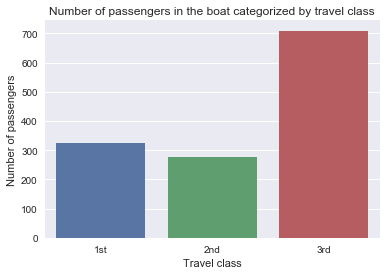

In [371]:
ax = sns.countplot(x="pclass", data=dsheet)
ax.set(xlabel='Travel class', ylabel='Number of passengers')
ax.set_title('Number of passengers in the boat categorized by travel class')

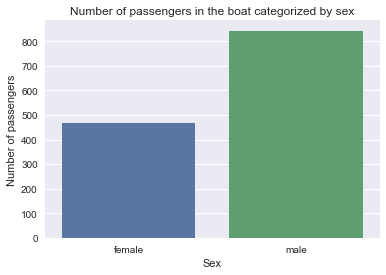

In [372]:
# 2. Plotting histogram of sex/ age and embarkation port
ax = sns.countplot(x="sex", data=dsheet)
ax.set(xlabel='Sex', ylabel='Number of passengers')
ax.set_title('Number of passengers in the boat categorized by sex')

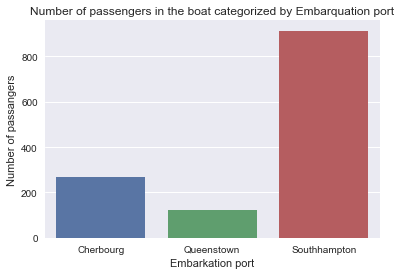

In [373]:
ax = sns.countplot(x="embarked", data=dsheet)
ax.set(xlabel='Embarkation port', ylabel='Number of passangers')
ax.set_title('Number of passengers in the boat categorized by Embarquation port')

To plot the following histogram, we discretized the age values in 8 intervals of size 10 each

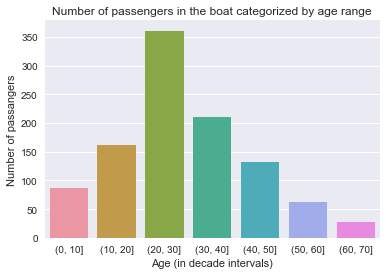

In [374]:
minBin = int((dsheet['age'].min()//10)*10)
maxBin = int((dsheet['age'].max()//10)*10)
bins = list(range(minBin, maxBin, 10))[1:]

ages = pd.cut(dsheet['age'],range(minBin, maxBin,10))
ax = sns.countplot(ages)
ax.set(xlabel='Age (in decade intervals)', ylabel='Number of passangers')
ax.set_title('Number of passengers in the boat categorized by age range')

**Question 3**

(-1.176336176668217,
 1.188381281696447,
 -1.1901682667360833,
 1.2090553300019111)

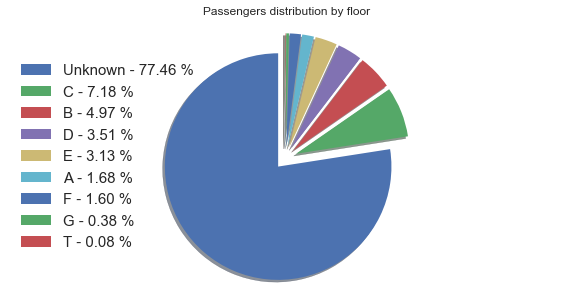

In [375]:
# Here we assumed that the floors are represented by the first letter in the Cabin code
from matplotlib import cm
import matplotlib.pyplot as plt

# Count the number of passengers by floor
value_count = dsheet['floor'].value_counts()

# set pie chart parameters and draw it 
labels = list(value_count.index)
sizes = value_count.values
explode = [0.1]*len(sizes)
fig1, ax1 = plt.subplots(sharex=True, figsize=(10,5))
patches, texts = ax1.pie(sizes, explode=explode,
        shadow=True, startangle=90,labeldistance=1.05)

# Set legend parameters and print it at the left of our pie chart
sizes = sizes*100/ sum(sizes)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, sizes)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, value_count.values),
                                          key=lambda x: x[2],
                                          reverse=True))
ax1.legend(patches, labels, loc='center left',
           fontsize=15)
plt.title('Passengers distribution by floor')


ax1.axis('equal')

**Question 4**<br>
Below are plotted the pie charts that represent the proportion of survived passengers by travel class, We noticed that there is no Nan entry in the survival column and the pclass column. Hence we will not deal with unkown values in our analysis

Pclass value range: [1st, 2nd, 3rd]
Categories (3, object): [1st, 2nd, 3rd] Survived value range: [1 0]


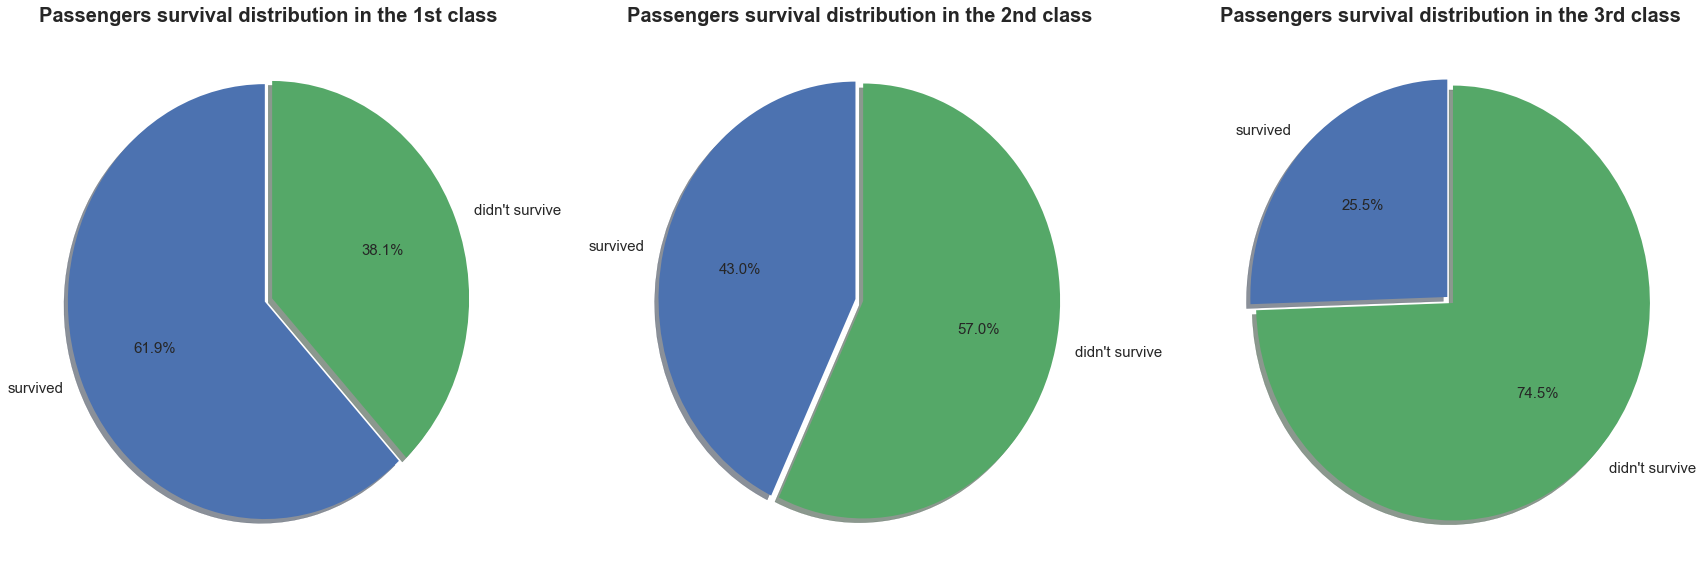

In [376]:
print('Pclass value range: {} Survived value range: {}'.format(dsheet.pclass.unique(),dsheet.survived.unique()))
# Filter only the surviving passenger,group by class and count the number of surviving passenger in each class
value_count_ones = dsheet.pclass[dsheet['survived'] == 1].value_counts()
value_count_totals = dsheet.pclass.value_counts()
colums_l = list(dsheet.pclass.cat.categories)

# Divide the number of surviving passenger in each class by the total number of passenger in each travel class
value_count_ones = (value_count_ones/value_count_totals)

# Set pie chart parameters
labels = ['survived',"didn't survive"]
explode = [0.02]*2
fig1, ax1 = plt.subplots(1,3)
fig1.set_figheight(10)
fig1.set_figwidth(30)

# Draw a pie chart for each travel class
for i in range(3):
    ax1[i].set_title('Passengers survival distribution in the {} class'.format(colums_l[i]),fontsize=20,fontweight="bold")
    patches, texts, autotexts = ax1[i].pie([value_count_ones[i],(1-value_count_ones[i])], explode=explode, labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
    for j in range(len(texts)):
        texts[j].set_fontsize(15)
        autotexts[j].set_fontsize(15)

    

**Question 5**

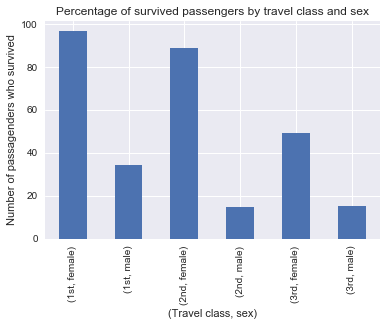

In [377]:
# Compute the number of the surviving passenger and the number of the dead passenger groupped by travel class and sex
groupped_data_pclass_sex = dsheet.groupby(['pclass','sex']).survived
survived_pclass_sex = groupped_data_pclass_sex.sum()

# Compute the passengers survival percentage
total_pclass_sex = groupped_data_pclass_sex.count()
proportion_pclass_sex = (survived_pclass_sex/total_pclass_sex)*100

# Draw the histogram
plt.figure()
proportion_pclass_sex.plot.bar()
plt.title('Percentage of survived passengers by travel class and sex')
plt.xlabel('(Travel class, sex)')
plt.ylabel('Number of passagenders who survived')

**Question6**

In [378]:
# Add a new columns which categorize the passenger in two equally populated age categories
dsheet['Age range']= pd.qcut(dsheet.age, 2).astype('category')

#Rename columns for visualization purposes
dsheet = dsheet.rename(columns = {'pclass':'Travel class', 'sex': 'Sex', 'survived':'Survived'})

# Compute the percentage of survival when the data is groupped by travel class, sex and age range and print the final dataframe
groupped_data_pclass_sex_age = dsheet.groupby(['Travel class','Sex','Age range']).Survived
final_dataframe = pd.DataFrame(groupped_data_pclass_sex_age.sum()*100/groupped_data_pclass_sex_age.count())
final_dataframe.columns = ['Survived percentage']
final_dataframe

Survived percentage
Travel class Sex    Age range                         
1st          female (0.166, 28.0]            95.121951
                    (28.0, 80.0]             96.739130
             male   (0.166, 28.0]            53.125000
                    (28.0, 80.0]             30.252101
2nd          female (0.166, 28.0]            91.071429
                    (28.0, 80.0]             87.234043
             male   (0.166, 28.0]            21.621622
                    (28.0, 80.0]              8.333333
3rd          female (0.166, 28.0]            51.376147
                    (28.0, 80.0]             37.209302
             male   (0.166, 28.0]            18.303571
                    (28.0, 80.0]             14.400000